In [5]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras_preprocessing.image import ImageDataGenerator


from src.ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCnn_Feit-reduced-rgb-no-inception"


/home/jelinek/recetox


In [6]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = keras.layers.Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='same')(inputs)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=256, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=512, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=11, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

In [9]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

Model: "MySimpleCnnFewerLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 

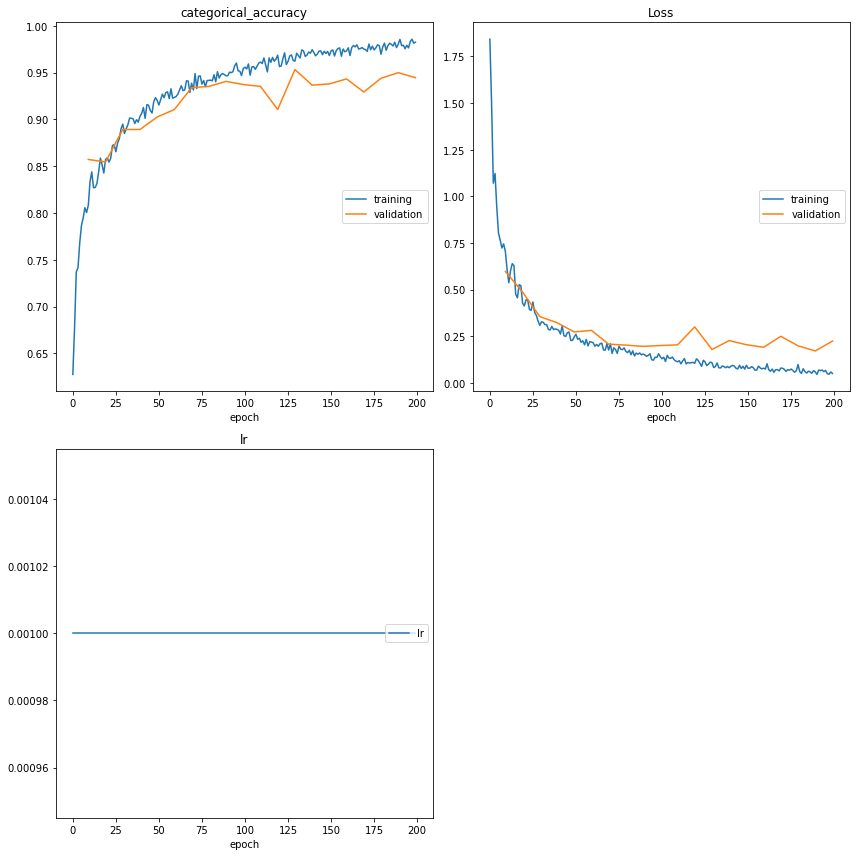

categorical_accuracy
	training         	 (min:    0.628, max:    0.986, cur:    0.983)
	validation       	 (min:    0.855, max:    0.953, cur:    0.945)
Loss
	training         	 (min:    0.045, max:    1.843, cur:    0.050)
	validation       	 (min:    0.171, max:    0.598, cur:    0.224)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
94/94 [==============================] - 5s 48ms/step - loss: 0.2243 - categorical_accuracy: 0.9446
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.3691ms
Confusion Matrix
[[316   1   3   0   4   0   0   0   0   0  11]
 [  0  45  13   1   2   0   1   1   0   0   1]
 [  1   1 135   0   7   0   0   1   0   0   0]
 [  0   0   0  10   1   0   0   0   0   0   0]
 [  0   0   0   1 543   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   6   8   0   0   0  62   1   0   0   0]
 [  0   0   6   1   0   0   1  78   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0

In [10]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [11]:
pipeline.save_pipeline()

In [12]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           name,
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1499 images belonging to 11 classes.
94/94 [==============================] - 5s 48ms/step - loss: 0.2243 - categorical_accuracy: 0.9446
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.3465ms
Confusion Matrix
[[316   1   3   0   4   0   0   0   0   0  11]
 [  0  45  13   1   2   0   1   1   0   0   1]
 [  1   1 135   0   7   0   0   1   0   0   0]
 [  0   0   0  10   1   0   0   0   0   0   0]
 [  0   0   0   1 543   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   6   8   0   0   0  62   1   0   0   0]
 [  0   0   6   1   0   0   1  78   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0]
 [  8   0   0   0   0   0   0   0   0   0 226]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.97      0.94      0.96       335
          blood_and_vessels       0.83      0.70      0.76        64
          connec

In [7]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [8]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=False, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1, use_sampling=True)

Processing region 120 out of 120
Post-processing image...
Processing grid point 663499 out of 663499
Processing image took 2402.7229373455048 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 1599360 out of 1599360
Processing image took 6106.3985340595245 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 1544036 out of 1544036
Processing image took 5691.200436592102 seconds
Processing region 567 out of 567
Post-processing image...
Processing grid point 3520448 out of 3520448
Processing image took 17761.20197415352 seconds
[[373350   5206  10745     86   2668      0     21    363      0      0
  136672]
 [     0      0      0      0      0      0      0      0      0      0
       0]
 [   667   7686  21114   4411   3378      0   3996   4488      0      0
    6826]
 [   241    771      0   1552    359      0      1      0      0      0
    9601]
 [   989   5554   3087  54156 178635      0   3699   6733      0    